In [315]:
# Libraries Imports
#-----------------------------------------------------------------------------------------------------
from configparser import ConfigParser
from sqlalchemy import create_engine
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import date, timedelta
import plotly.express as px
import plotly.graph_objects as go


In [317]:
# Load connexion configuration file
#-----------------------------------------------------------------------------------------------------
config_filename = "./conf/GetWeather.ini"

# Read config.ini file
config_object = ConfigParser()
config_object.read(config_filename)
if  not config_object:
    print("Error while loading configuration !!!")

# Log initialization
cfg = config_object['INFO']

In [318]:
# Establish connection with DB (using sqlalchemy)
#-----------------------------------------------------------------------------------------------------
db_connection_str = "mysql+pymysql://{}:{}@{}/WeatherDB".format(cfg['user'],cfg['password'],cfg['host'])
db_connection = create_engine(db_connection_str)

In [6]:
# Count sorted number of records per locations
#-----------------------------------------------------------------------------------------------------
raw_data = pd.read_sql(
"""SELECT Locations.name as name, COUNT(*) as nbRecords
FROM RawRecords
INNER JOIN Locations ON RawRecords.id_location = Locations.id
GROUP BY id_location
ORDER BY nbRecords DESC;""", con=db_connection)
pdata = pd.DataFrame(raw_data)

# Display header just to be sure we have something
pdata.head(10)


,name,nbRecords
0,Hérémence,4379
1,Geneva,4208
2,Lausanne,4181
3,Sion,3863
4,Evolène,3327


In [ ]:
# Get average values on all records per locations
#-----------------------------------------------------------------------------------------------------
raw_data = pd.read_sql(
"""SELECT 
	    id_location, 
        Locations.name,
	    ROUND(AVG(pressure),2) AS avgPress,
	    ROUND(AVG(temp - 271.15),2) AS avgTemp,
	    ROUND(AVG(humidity),2) AS avgHumidity
    FROM Records
    INNER JOIN Locations on id_location = Locations.id
    GROUP BY id_location;""", con=db_connection)
pdata = pd.DataFrame(raw_data)

# Display header just to be sure we have something
pdata.head(10)


In [ ]:
# Get minimum values per locations
#-----------------------------------------------------------------------------------------------------
raw_data = pd.read_sql(
""" SELECT 
	    id_location, 
        Locations.name,
	    ROUND(MIN(pressure),2) AS MINPress,
	    ROUND(MIN(temp - 271.15),2) AS MINTemp,
	    ROUND(MIN(humidity),2) AS MINHumidity
    FROM Records
    Inner join Locations on id_location = Locations.id
    group by id_location;;""", con=db_connection)
pdata = pd.DataFrame(raw_data)

# Display header just to be sure we have something
pdata.head(10)

In [ ]:
# Hourly stats for a given day at a given location
#-----------------------------------------------------------------------------------------------------
my_date='2021-08-10'
loc = 6
raw_data = pd.read_sql(""" call Get_Hourly_Stats('{}',{});""".format(my_date, loc), con=db_connection)
pdata = pd.DataFrame(raw_data)

# Display header just to be sure we have something
pdata.head(30)

In [ ]:
# Get hourly stats for a given range of day(s) and a single location
#-----------------------------------------------------------------------------------------------------
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

# work variables for aggregation
start_date = date(2021,1,1)
end_date = date(2022,1,1)
loc = 6
pdata = pd.DataFrame([])
flagFirstRec = True
iter = 0

for my_date in daterange(start_date, end_date):
    iter += 1
    query = "call Get_Hourly_Stats('{}',{});".format(my_date, loc)
    raw_data = pd.read_sql(query, con=db_connection)
   
    if flagFirstRec:
        pdata = pd.DataFrame(raw_data)
        flagFirstRec = False
    else:
        pdata = pdata.append(pd.DataFrame(raw_data))
    
print("{} aggregate(s) created for a period of {} day(s).".format(pdata.shape,iter))

In [ ]:
#pdata.insert(0, 'idx', range(0,len(pdata)))
pdata.reset_index(drop=True)

In [ ]:
my_date = '2021-08-23'
loc = 6
query = "call Get_Monthly_Stats('{}',{});".format(my_date, loc)

pdata = pd.read_sql(query, con=db_connection)
pdata.rename(columns = {'date_timestamp':'timestamp'}, inplace = True)
pdata.insert(0,'id',0)
pdata.head(5)



In [91]:
pdata.to_sql('RecordsByHour', con=db_connection, if_exists='append',
           index=False)

In [ ]:
# TimeZone tools to get if measures are UTC/CET
from pytz import all_timezones
for timezone in all_timezones:
    print(timezone)

In [319]:
# Daily stats
#-----------------------------------------------------------------------------------------------------
queryDate = datetime.today().strftime('%Y-%m-%d')
#queryDate = '2021-09-03'
location = 6
raw_data = pd.read_sql(
"""
SELECT Locations.name, date_timestamp, hour(date_timestamp) as hour, (temp-273.15) as temp, pressure,humidity, clouds_cover, rain_1h, snow_1h,wind_dir,wind_speed 
FROM RawRecords
INNER JOIN Locations ON RawRecords.id_location = Locations.id
WHERE RawRecords.date_timestamp >= '{}' AND  RawRecords.id_location = {}
GROUP BY HOUR(date_timestamp)
ORDER BY HOUR(date_timestamp)
""".format(queryDate, location), con=db_connection)
pdata = pd.DataFrame(raw_data)
pdata.head(100)


,name,date_timestamp,hour,temp,pressure,humidity,clouds_cover,rain_1h,snow_1h,wind_dir,wind_speed
0,Hérémence,2021-09-16 00:00:03,0,13.240015,1018.0,97.0,75,0.00,0.0,90,1.54
1,Hérémence,2021-09-16 01:00:01,1,13.029993,1018.0,97.0,20,0.00,0.0,0,1.54
2,Hérémence,2021-09-16 02:00:02,2,12.890009,1018.0,97.0,100,0.00,0.0,0,0.00
3,Hérémence,2021-09-16 03:00:02,3,12.689996,1018.0,97.0,95,0.00,0.0,0,0.00
4,Hérémence,2021-09-16 04:00:02,4,12.689996,1018.0,94.0,75,0.00,0.0,0,0.51
5,Hérémence,2021-09-16 05:00:02,5,12.179987,1017.0,97.0,20,0.00,0.0,0,0.00
6,Hérémence,2021-09-16 06:00:03,6,12.279993,1017.0,98.0,75,0.00,0.0,0,0.00
7,Hérémence,2021-09-16 07:01:34,7,12.159998,1017.0,98.0,75,0.00,0.0,0,0.00
8,Hérémence,2021-09-16 08:00:02,8,12.159998,1017.0,98.0,75,0.00,0.0,110,1.54
9,Hérémence,2021-09-16 09:00:02,9,12.339990,1018.0,98.0,75,0.00,0.0,60,1.54


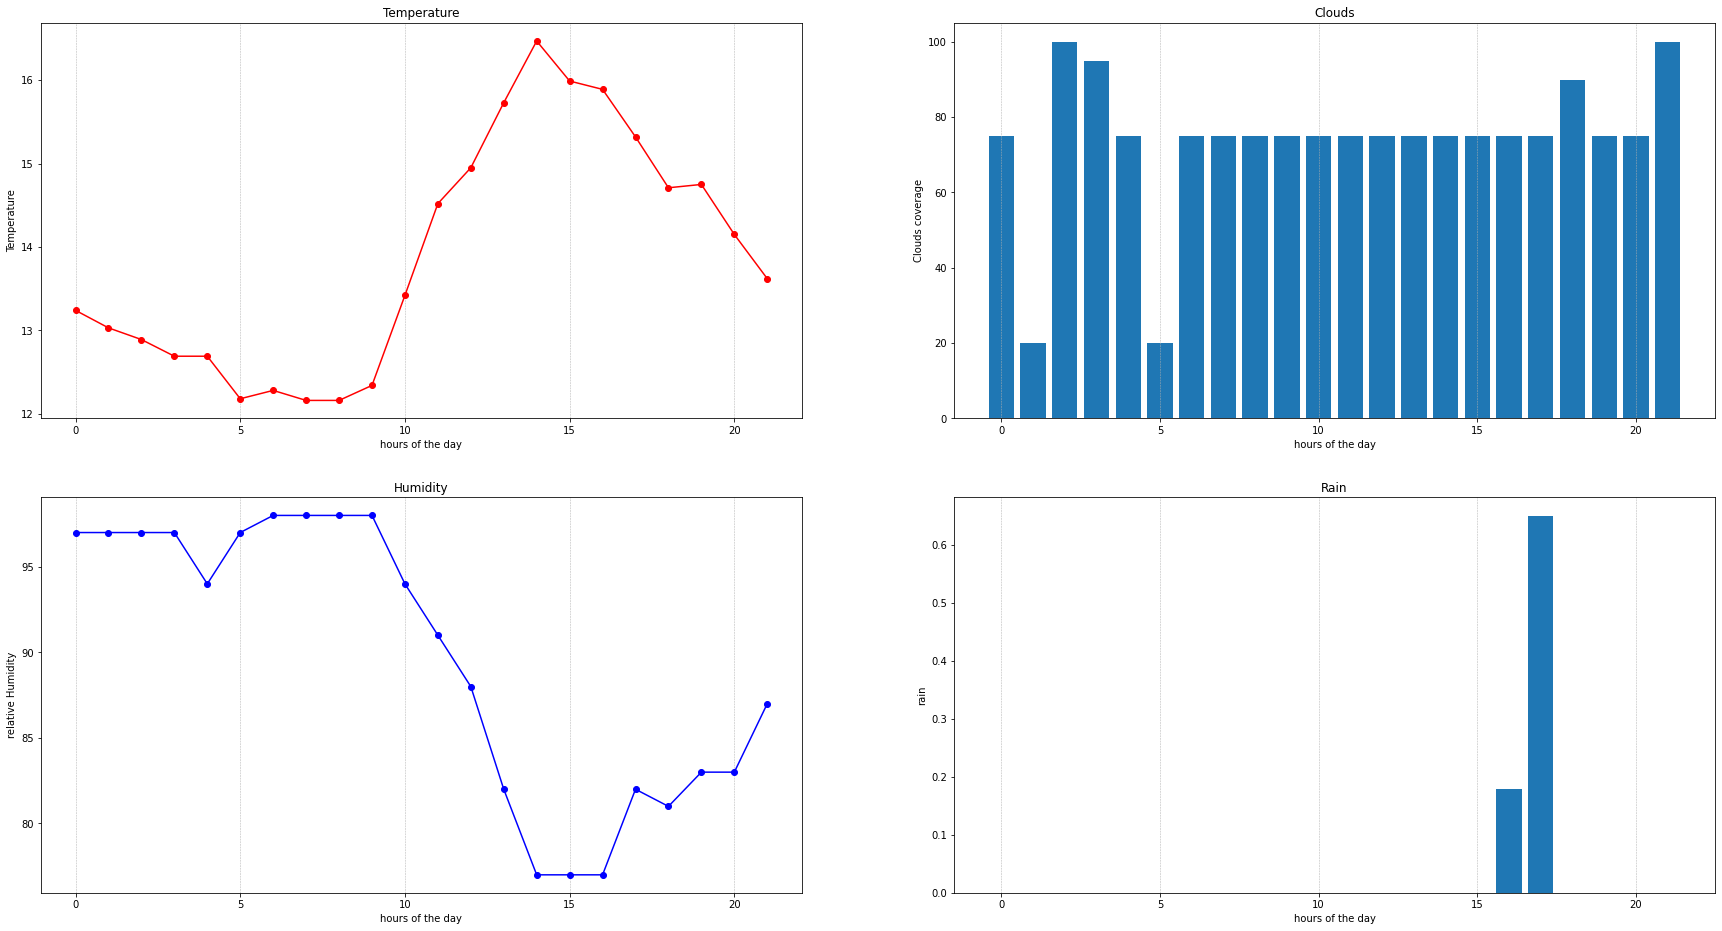

<Figure size 432x288 with 0 Axes>

In [320]:
# Set plot size
plt.figure(figsize=(30, 16))

# draw temp curve with pyplot
plt.subplot(2, 2, 1)
xpoints = raw_data['hour'].tolist()
ypoints = raw_data['temp'].tolist()
plt.title("Temperature")
plt.xlabel("hours of the day")
plt.ylabel("Temperature")
plt.grid(axis = 'x',linestyle='--',linewidth=0.5)
display(plt.plot(xpoints, ypoints, 'o-r', linewidth=1.5))

# draw cloud cover percentage
plt.subplot(2, 2, 2)
ypoints = raw_data['clouds_cover'].tolist()
plt.title("Clouds")
plt.xlabel("hours of the day")
plt.ylabel("Clouds coverage")
plt.grid(axis = 'x',linestyle='--',linewidth=0.5)
#plt.plot(xpoints, ypoints, 'o-g', linewidth=1.5)
plt.bar(xpoints,ypoints)

# draw humidity cover percentage
plt.subplot(2, 2, 3)
ypoints = raw_data['humidity'].tolist()
plt.title("Humidity")
plt.xlabel("hours of the day")
plt.ylabel("relative Humidity")
plt.grid(axis = 'x',linestyle='--',linewidth=0.5)
plt.plot(xpoints, ypoints, 'o-b', linewidth=1.5)

# draw rain barchart
plt.subplot(2, 2, 4)
ypoints = raw_data['rain_1h'].tolist()
plt.title("Rain")
plt.xlabel("hours of the day")
plt.ylabel("rain")
plt.grid(axis = 'x',linestyle='--',linewidth=0.5)
plt.bar(xpoints,ypoints)
plt.show()
# Super title
plt.suptitle("Weather today")

# Show graphs
plt.show()



In [301]:
import plotly.express as px
df = px.data.wind()
fig = px.bar_polar(df, r="frequency", theta="direction",
                   color="strength", template="plotly_dark",
                   color_discrete_sequence= px.colors.sequential.Plasma_r)
fig.show()


In [52]:
df.tail(20)


,direction,strength,frequency
108,W,5-6,0.40
109,WNW,5-6,0.70
110,NW,5-6,0.70
111,NNW,5-6,0.40
112,N,6+,0.10
113,NNE,6+,0.10
114,NE,6+,0.10
115,ENE,6+,0.10
116,E,6+,0.10
117,ESE,6+,0.05


In [17]:
df[df['direction'] == 'N']

,direction,strength,frequency
0,N,0-1,0.5
16,N,1-2,1.6
32,N,2-3,0.9
48,N,3-4,0.9
64,N,4-4,0.4
80,N,4-5,0.3
96,N,5-6,0.2
112,N,6+,0.1


In [289]:
nt = np.NaN
nt = pd.DataFrame(raw_data['wind_speed'])
nt.insert(1,'wind_dir',raw_data['wind_dir'],allow_duplicates=True)
nt = nt.groupby('wind_dir')
s = nt['wind_dir'].agg([np.size])
s



,size
wind_dir,
0,12
60,1
70,1
80,2
90,2
100,1
230,1
250,3


In [280]:
for wd in s.index:
    print("{}".format(wd))



0
60
70
80
90
100
230
250


In [ ]:
list = s['size']

for iter in list:
    print("{}".format(iter))


In [254]:
tagg = raw_data.groupby('wind_dir')
tagg = tagg.agg({'wind_dir':np.size, 'wind_speed':np.average})
tagg[::-1]


,wind_dir,wind_speed
wind_dir,,
100,1,2.060000
90,2,1.800000
80,2,2.060000
70,1,2.060000
60,1,1.540000
0,12,0.641667


In [ ]:

#
print("header {}".format(grouped['wind_dir'].agg([np.size])))
#nt.insert(1,'freq',sf.to_list(),allow_duplicates=True)
sf = nt['wind_dir'].value_counts(normalize=True)


In [51]:

fig = go.Figure()
ws = raw_data[raw_data['wind_speed'].between(0,1)]

fig.add_trace(
    go.Barpolar(
        r=ws['wind_speed'],
        theta=ws['wind_dir'],
        name='0-1 m/s',
        marker_color='rgb(106,81,163)'
        
    )
)


fig.update_traces(text=['North', 'N-E', 'East', 'S-E', 'South', 'S-W', 'West', 'N-W'])
fig.update_layout(
    title='Wind Speed Distribution ',
    font_size=16,
    legend_font_size=8,
    polar_radialaxis_ticksuffix='%',
    polar_angularaxis_rotation=1,


)
fig.show()

In [1]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print("Setup Complete")

Setup Complete


In [2]:
raw_data[raw_data['wind_speed'].between(0,1)]
raw_data[raw_data['wind_speed'].between(1,2)]
raw_data[raw_data['wind_speed'].between(2,3)]
raw_data[raw_data['wind_speed'].between(3,4)]
ws = raw_data[raw_data['wind_speed'].between(0,10)]
ws['wind_dir']

NameError: name 'raw_data' is not defined

<AxesSubplot:ylabel='temp'>

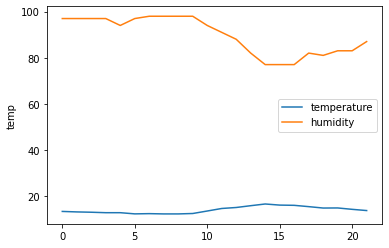

In [324]:
import seaborn as sb
sb.lineplot(data=raw_data['temp'], label='temperature')
sb.lineplot(data=raw_data['humidity'],label='humidity')

<AxesSubplot:ylabel='temp'>

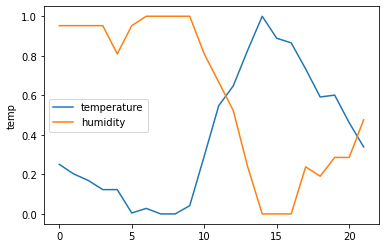

In [338]:
dt = (raw_data['temp'] - raw_data['temp'].min()) / (raw_data['temp'].max() - raw_data['temp'].min())
dh = (raw_data['humidity'] - raw_data['humidity'].min()) / (raw_data['humidity'].max() - raw_data['humidity'].min())
sb.lineplot(data=dt, label='temperature')
sb.lineplot(data=dh,label='humidity')


In [342]:
print("temperature min : {} C°  max : {} C° delta : {} C°".format(raw_data['temp'].min(),raw_data['temp'].max(),raw_data['temp'].max() - raw_data['temp'].min()))
print("humidity min    : {} %   max : {} %  delta : {} %".format(raw_data['humidity'].min(),raw_data['humidity'].max(),raw_data['humidity'].max() - raw_data['humidity'].min()))


temperature min : 12.159997558593773 C°  max : 16.469995117187523 C° delta : 4.30999755859375 C°
humidity min    : 77.0 %   max : 98.0 %  delta : 21.0 %


<AxesSubplot:>

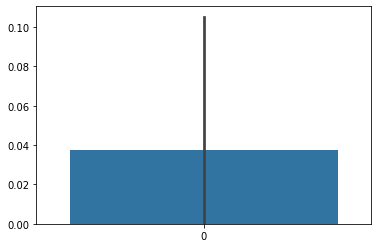

In [339]:
sb.barplot(data=raw_data['rain_1h'],label='rain')